In [1]:
import os
import sys
import random
from datetime import datetime


sys.path.append('../src')

from design_gene_blocks import DesignEblocks
from design_IVA_primers import DesignPrimers
from snapgene_output import SnapGeneOutput

%load_ext autoreload
%autoreload 2

In [2]:
# TODO INSTALL THIS IN ENVIRONMENT AND JUPYTER ENVIRONMENT (MAKE SAME ENVIRONMENT)
# !pip3 install openpyxl

In [3]:
# TODO ADD IMAGE OF THE VECTOR

In this tutorial we will randomly design a number of mutations for the replicative DNA polymerase DnaE1 from *Mycobacterium smegmatis* to better understand it's function. <br>

The expression plasmid containing Msmeg DnaE1 is XXX and is stored in XXX. <br>

Gene from mycobrowser XXX and is stored in XXX <br>

In [4]:
# File locations for input and output

vector = 'files/snapgene_vector.dna' # TODO Change name and change vector (see snapgene computer which one to take)
msmeg_dnae1 = 'files/A0QX55.fasta'  # M. smegmatis DnaE1 gene
output_location = 'output/'  # Location to store the files created in this notebook
codon_usage = 'Mycobacterium Smegmatis' # We want to use the codon usage of this organism
codon_usage_fp = r"C:\Users\Rosan\Documents\git\my_repositories\design_gene_blocks\src\data\codon_usage" # Location of the codon usage files

First we open the nucleotide sequence of Msmeg DnaE1 and translate this to the protein sequence. Here, the start and stop codon are not translated 

In [5]:
# Load the nucleotide sequence

msmeg_dnae1_dna = DesignEblocks.read_seq(msmeg_dnae1)
print("Nucleotide sequence: ", msmeg_dnae1_dna)

# Translate nucleotide to protein sequence

msmeg_dnae1_protein = msmeg_dnae1_dna.translate()
print("Protein sequence: ", msmeg_dnae1_protein)

# Create a list of all DnaE1 residues

msmeg_dnae1_residues = [i + str(j) for i, j in zip(msmeg_dnae1_protein, range(1, len(msmeg_dnae1_protein) + 1))]
print("Residues: ", msmeg_dnae1_residues)

Nucleotide sequence:  atgagcggttcatctgcggggtcctccttcgtgcacctgcacaaccacaccgagtattcgatgctggacggtgccgcgaagatcacgcccatgctcgccgaggtggagcggctggggatgcccgcggtggggatgaccgaccacggaaacatgttcggtgccagcgagttctacaactccgcgaccaaggccgggatcaagccgatcatcggcgtggaggcatacatcgcgccgggctcgcggttcgacacccggcgcatcctgtggggtgaccccagccaaaaggccgacgacgtctccggcagcggctcctacacgcacctgacgatgatggccgagaacgccaccggtctgcgcaacctgttcaagctgtcctcgcatgcttccttcgagggccagctgagcaagtggtcgcgcatggacgccgagctcatcgccgaacacgccgagggcatcatcatcaccaccggatgcccgtcgggggaggtgcagacccgcctgcggctcggccaggatcgggaggcgctcgaagccgcggcgaagtggcgggagatcgtcggaccggacaactacttccttgagctgatggaccacgggctgaccatcgaacgccgggtccgtgacggtctgctcgagatcggacgcgcgctcaacattccgcctcttgccaccaatgactgccactacgtgacccgcgacgccgcccacaaccatgaggctttgttgtgtgtgcagaccggcaagaccctctcggatccgaatcgcttcaagttcgacggtgacggctactacctgaagtcggccgccgagatgcgccagatctgggacgacgaagtgccgggcgcgtgtgactccaccttgttgatcgccgaacgggtgcagtcctacgccgacgtgtggacaccgcgcgaccggatgcccgtgtttccggtgcccgatgggcatgaccaggcgtcctggctgcgtcacgaggtggac

Now we will randomly design some mutations for this gene. Here, we will not generate any mutations in the N- or C- terminal region, to ensure we can create a 20bp overlap with the beginning or end of the gene in our eBlock design <br>

1. **Single point mutations** <br>

Single point mutations contain a single mutation per eBlock

2. **Multiple point mutations in same eBlock**

Multiple point mutations contain multiple mutations in the same eBlock

3. **Inserts**

Inserts contain addition of amino acids in the eBlock

4. **Deletions**

Deletions have parts of the gene deleted

In [6]:
# List containing all natural amino acids and options for our mutations
choices = ['A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'S', 'T', 'N', 'Q', 'C', 'G', 'P', 'R', 'H', 'K', 'D', 'E']

# Set of functions to randomly select mutations and insertions/deletions

def random_single_mutation(residues, choices, n):
    """
    Randomly select single mutations in a protein sequence.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    choices : list
        List of all natural amino acids
    n : int
        Number of mutations to sample
    """
    res = random.sample(residues, n)
    mut = random.sample(choices, n)
    mutants = [i + j for i, j in zip(res, mut)]
    return mutants


def random_multiple_mutation(residues, choices, n, max_distance_between_mutants=5, max_number_mutations=4):
    """
    Randomly select multiple mutations in a protein sequence that will be combined in one mutant.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    choices : list
        List of all natural amino acids
    n : int
        Number of mutations to sample
    max_distance_between_mutants : int
        Maximum distance (in residues) between the two mutations, default is set to 10
    """
    mutants = []  # List to store the mutants
    res1 = random.sample(residues, n)
    var1=  random.sample(choices, n)
    mut1 = [i + j for i, j in zip(res1, var1)]
    for i in mut1:
        temp_muts = []
        num_mutations = random.sample(range(1, max_number_mutations), 1)[0]
        pos_x = random.sample(range(1, max_distance_between_mutants), num_mutations)
        vars_x = random.sample(choices, num_mutations)
        for j, k in zip(pos_x, vars_x):
            mut_x = residues[int(i[1:-1]) + j] + k
            temp_muts.append(mut_x)
        mutants.append(i + '-' + '-'.join(temp_muts))
    return mutants


def random_insert(residues, choices, n, max_length_insertion=10):
    """
    Randomly generate insertions in a protein sequence.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    choices : list
        List of all natural amino acids
    n : int
        Number of insertions to sample
    max_length_insertion : int 
        Maximum length of the insertion, default is set to 10
    """
    inserts = []  # List to store the inserts
    for i in range(n):
        len_insertion = random.sample(range(1, max_length_insertion), 1)[0]
        insertion = random.sample(choices, len_insertion)
        insertion = ''.join(insertion)
        residue = random.sample(residues, 1)[0]
        insert = residue + '-' + insertion
        inserts.append(insert)
    return inserts


def random_deletion(residues, n, max_length_deletion=10):
    """
    Randomly generate deletions in a protein sequence.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    n : int
        Number of deletions to sample
    max_length_deletion : int
        Maximum length of the deletion, default is set to 10
    """
    deletions = []
    for i in range(n):
        len_deletion = random.sample(range(1, max_length_deletion), 1)[0]
        res_b = random.sample(residues, 1)[0]
        res_e = residues[residues.index(res_b) + len_deletion]
        deletion = res_b + '-' + res_e
        deletions.append(deletion)
    return deletions

In [7]:
# TODO FIX INDEX ERROR (INDEX OUT OF RANGE) FOR DOUBlE MUTATIONS

# Randomly select single mutations
number_single = 20
selected_single_mutants = random_single_mutation(msmeg_dnae1_residues[25:-25], choices, number_single)
print(f"Generated {number_single} single mutations: ", selected_single_mutants)

# Randomly select double mutations
number_double = 2
selected_double_mutants = random_multiple_mutation(msmeg_dnae1_residues[25:-25], choices, number_double)
print(f"Generated {number_double} paired mutations: ", selected_double_mutants)

# Randomly select insertions
number_insertions = 2
selected_insertions = random_insert(msmeg_dnae1_residues[25:-25], choices, number_insertions)
print(f"Generated {number_insertions} insertions: ", selected_insertions)

# Randomly select deletions
number_deletions = 2
selected_deletions = random_deletion(msmeg_dnae1_residues[25:-25], number_deletions)
print(f"Generated {number_deletions} deletions: ", selected_deletions)

total_number_mutations = number_single + number_double + number_insertions + number_deletions
print(f"Total number of mutations: {total_number_mutations}")

Generated 20 single mutations:  ['G199I', 'S100A', 'P307G', 'Y370C', 'L193Y', 'S251P', 'D1051S', 'D971L', 'L591W', 'R480D', 'E212E', 'S1160N', 'V904T', 'S898F', 'T1118K', 'A393M', 'S929H', 'R686Q', 'I537V', 'N1081R']
Generated 2 paired mutations:  ['G753L-A782T', 'L242W-M271M-R272A-E270Y']
Generated 2 insertions:  ['R682-TSH', 'K1039-TFDHLQ']
Generated 2 deletions:  ['D620-Y625', 'G958-D961']
Total number of mutations: 26


In [8]:
# Formatting the mutations in a format that can be read by the DesignEblocks class, see documentation for more information about this

now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H:%M")
mutationsfile = f'files/mutations_random_Msmeg_DnaE1_N{total_number_mutations}_{dt_string}.txt'

with open(mutationsfile, 'w') as f:
    for i in selected_single_mutants:
        f.write(i + '\n')
    for i in selected_double_mutants:
        f.write('Combined ' + i + '\n')
    for i in selected_insertions:
        f.write('Insert ' + i + '\n')
    for i in selected_deletions:
        f.write('Deletion ' + i + '\n')

Now that we have selected the mutations that we want to create, we can start the design of the eBlocks. <br>
First, we create an instance of the DesignEblocks class and provide the information. Next we will start the design of the eBlocks. <br>
<br>

TODO: Describe the steps that are carried out in this class

In [9]:
# Create instance of DesignEblocks to design the eBlocks per mutation

eBlocks_instance = DesignEblocks(
                        sequence_fp=msmeg_dnae1,
                        mutations_fp=mutationsfile,
                        output_fp=output_location,
                        species=codon_usage,
                        codon_usage_fp=codon_usage_fp)

In [10]:
# TODO BEFORE STARTING ACTUALLY MAKE A PLOT OF HOW THE MUTATIONS ARE DIVIDED OVER THE PROTEIN
# TODO THINK ABOUT HOW TO DO THIS 
# TODO DO USING SAME PACKAGE AS BELOW

In [16]:
print(eBlocks_instance.mutation_types)

['Mutation', 'Mutation', 'Mutation', 'Mutation', 'Mutation', 'Mutation', 'Mutation', 'Mutation', 'Mutation', 'Mutation', 'Mutation', 'Mutation', 'Mutation', 'Mutation', 'Mutation', 'Mutation', 'Mutation', 'Mutation', 'Mutation', 'Mutation', 'Combined', 'Combined', 'Insert', 'Insert', 'Deletion', 'Deletion']


idx_dna  [597, 300, 921, 1110, 579, 753, 3153, 2913, 1773, 1440, 636, 3480, 2712, 2694, 3354, 1179, 2787, 2058, 1611, 3243, 2259, 2346, 726, 813, 816, 810, 2046, 3117, 1860, 2874]
idx_dna_tups  [['G199I', 597], ['S100A', 300], ['P307G', 921], ['Y370C', 1110], ['L193Y', 579], ['S251P', 753], ['D1051S', 3153], ['D971L', 2913], ['L591W', 1773], ['R480D', 1440], ['E212E', 636], ['S1160N', 3480], ['V904T', 2712], ['S898F', 2694], ['T1118K', 3354], ['A393M', 1179], ['S929H', 2787], ['R686Q', 2058], ['I537V', 1611], ['N1081R', 3243], [['G753L', 2259], ['A782T', 2346]], [['L242W', 726], ['M271M', 813], ['R272A', 816], ['E270Y', 810]], ['R682-TSH', 2046], ['K1039-TFDHLQ', 3117], ['D620-Y625', 1860], ['G958-D961', 2874]]
30 26
Optimizing bin sizes ...
Optimal bandwidth:  279
Clusters:  {'cluster 0': [597, 300, 921, 1110, 579, 753, 636, 1179, 726, 813, 816, 810], 'cluster 1': [3153, 2913, 3480, 2712, 2694, 3354, 2787, 3243, 3117, 2874], 'cluster 2': [2058, 2259, 2346, 2046], 'cluster 3': [1773, 1

SystemExit: 

c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\IPython\core\interactiveshell.py:3450: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


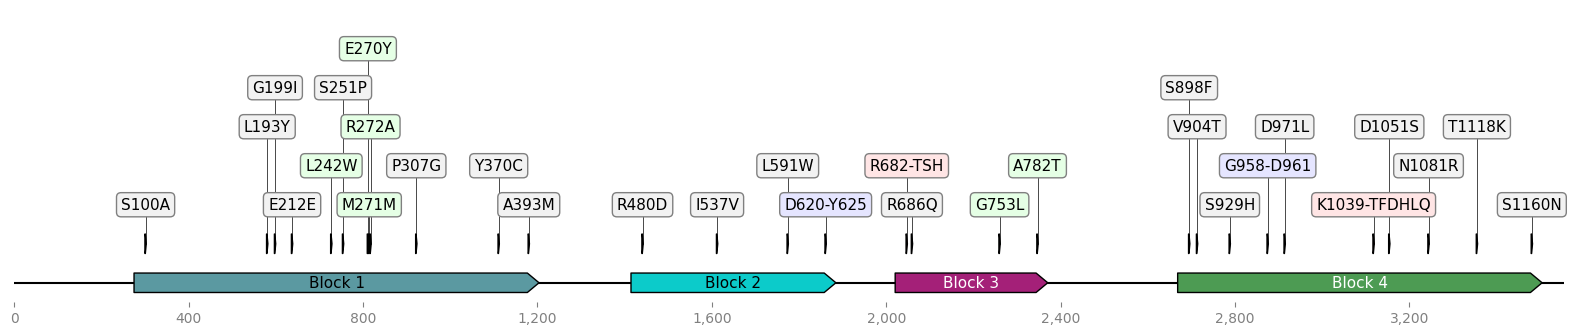

In [45]:
# Run the design of the eBlocks

eBlocks_instance.run()

In [ ]:
# TODO ADD THE MUTATIONS IN THE PLOT AS WELL
# TODO DECRIBE COLORS IN THE PLOT (MAKE INTO STATIS METHOD)
# TODO TRY WITH 100 mutations as well
# TODO PLOT THE COUNT PER EBLOCK AS WELL


In [70]:
# PRINT TOTAL NUMBER OF EBLOCKS HERE TO HIGHLIGHT THE GAIN WITH THE APPROACH

In [72]:
print(eBlocks_instance.output_fp)

output/


In [73]:
print(eBlocks_instance.logfile)

output/design_gene_blocks.log


S60
D428
A491
H127
Optimizing bin sizes ...
201
566.95
202
566.95
203
566.95
204
661.75
205
661.75
206
661.75
207
661.75
208
661.75
209
661.75
210
612.85
211
612.85
212
612.85
213
612.85
214
661.75
215
566.95
216
566.95
217
566.95
218
566.95
219
566.95
220
566.95
221
566.95
222
566.95
223
593.95
224
593.95
225
518.35
226
566.65
227
518.05
228
566.95
229
661.75
230
674.65
231
674.65
232
661.75
233
661.75
234
661.75
235
674.65
236
674.65
237
674.65
238
674.65
239
674.65
240
674.65
241
674.65
242
674.65
243
674.65
243
752.8
240
674.65
241
674.65
242
674.65
243
674.65
243
752.8
202
566.95
203
566.95
204
661.75
205
661.75
206
661.75
207
661.75
208
661.75
209
661.75
210
612.85
211
612.85
212
612.85
213
612.85
214
661.75
215
566.95
216
566.95
217
566.95
218
566.95
219
566.95
220
566.95
221
566.95
222
566.95
223
593.95
224
593.95
225
518.35
226
566.65
227
518.05
228
566.95
229
661.75
230
674.65
231
674.65
232
661.75
233
661.75
234
661.75
235
674.65
236
674.65
237
674.65
238
674.65
239
674.65
2

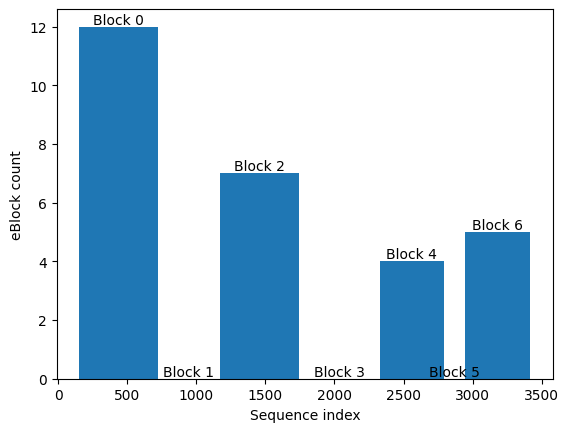

In [76]:
# run eblocks design



In [75]:
# TODO DESCRIBE WHAT CAN BE SEEN IN THE PLOT

In [ ]:
# DESCIBE WHAT OTHER FILES ARE CREATED



In [ ]:
# DECRIBE THE NEXT STEPS

In [77]:
# Next; design IVA primers to open up destination plasmid

mut_gene_blocks_fp = os.path.join(output_location, "mut_gene_blocks.npy")
wt_gene_blocks_fp = os.path.join(output_location, "wt_gene_blocks.npy")

# Create class instance

design_primers = DesignPrimers(wt_gene_blocks_fp=wt_gene_blocks_fp, 
                               mut_gene_blocks_fp=mut_gene_blocks_fp, 
                               output_location=output_location,
                               input_gene_path=gene,
                               snapgene_file=vector)

# Design the primers

design_primers.run()

# Also write results to files that SnapGene can open
primers_fp = os.path.join(output_location, "IVA_primers.csv")
gene_blocks_mutation_info_fp = os.path.join(output_location, "gene_blocks.txt")

# If you have SnapGene installed, you can add the mutations as features in this file

snapgene_output = SnapGeneOutput(wt_gene_blocks_fp = wt_gene_blocks_fp,
                                 mut_gene_blocks_fp = mut_gene_blocks_fp,
                                 primers_fp = primers_fp,
                                 output_location = output_location,
                                 snapgene_file = vector,
                                 gene_blocks_info_fp = gene_blocks_mutation_info_fp)
snapgene_output.run()


Block_2_pos_1169_1747
Block_6_pos_2948_3418
Block_4_pos_2327_2794
Block_0_pos_155_721
The template temperatures for Fw and Rv primer of Block_2_pos_1169_1747 exceed max Tm difference 4 degrees
The overhang temperatures for Fw and Rv primer of Block_0_pos_155_721 exceed max Tm difference of 4 degrees
Complementarity between the primers for Block_2_pos_1169_1747 exceeds threshold of 4
Complementarity between the primers for Block_6_pos_2948_3418 exceeds threshold of 4
Complementarity between the primers for Block_4_pos_2327_2794 exceeds threshold of 4
Primers written to file
Make sure that primer binds nowhere else in sequence
{'Block_2_pos_1169_1747': [1183, 1761], 'Block_6_pos_2948_3418': [2962, 3432], 'Block_4_pos_2327_2794': [2341, 2808], 'Block_0_pos_155_721': [169, 735]}
3335 3337
3134 3136
2492 2494
464 466
1733 1735
659 661
608 610
1205 1207
2378 2380
1454 1456
2984 2986
2363 2365
3116 3118
551 553
1463 1465
1505 1507
623 625
707 709
2780 2782
3404 3406
344 346
341 343
191 193
12

In [78]:
# TODO CLEANUP AND REMOVE UNNECCESSARY FILES